SVM - mean accuracies (std) 
 cat (specificity): 0.837500 (0.093076) 
 dog (recall): 0.792308 (0.053571) 
 overall: 0.814000 (0.045651) 

LogReg - mean accuracies (std) 
 cat (specificity): 0.800000 (0.111492) 
 dog (recall): 0.746154 (0.071336) 
 overall: 0.772000 (0.051147) 

RF - mean accuracies (std) 
 cat (specificity): 0.754167 (0.114791) 
 dog (recall): 0.776923 (0.075565) 
 overall: 0.766000 (0.062000) 

About 43.48 percent of mislabels by the SVM is shared by all models.
About 34.48 percent of mislabels by the LogReg is shared by all models.
About 43.48 percent of mislabels by the RF is shared by all models.


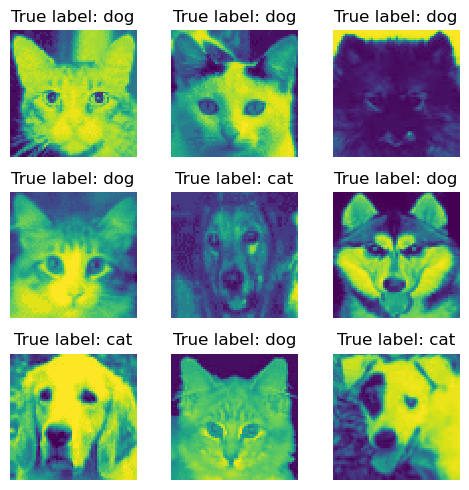

Fraction of missclassified dogs: 0.700000
Fraction of missclassified cats: 0.300000 
(according to algorithm)


In [7]:
import ipynb.fs.full.q1a as q1a

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, chi2, RFE

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1b.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


def write_data_file(df: pd.DataFrame, filename: str):
  path = Path(os.getcwd() + 'q1b.ipynb')
  data_folder = str(path.parent.absolute()) + '/data/'
  df.to_csv(data_folder + filename, index=False)


features = read_data_file('CATSnDOGS.csv') / 255
labels = read_data_file('Labels.csv')

models = [
          ('SVM', SVC()),
          ('LogReg', LogisticRegression(max_iter=1000)), 
          ('RF', RandomForestClassifier())
        ]


In [13]:
# Filter method: Variance filtering
def filter_variance(features: pd.DataFrame) -> pd.DataFrame:
    var = np.std(features.to_numpy(), axis=0) ** 2
    var_mean = np.mean(var)
    var_std = np.std(var)
    model = VarianceThreshold(threshold=var_mean+var_std)
    model.fit(features)
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data


# Filter method: Chi-squared test
def select_K_best(features: pd.DataFrame, labels: pd.DataFrame, k: int = 200) -> pd.DataFrame:
    model = SelectKBest(score_func=chi2, k=k).fit(features, labels)
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data


# Intrinsic method: Lasso regularization
def lasso_sparsfiy(features: pd.DataFrame, labels: pd.DataFrame) -> pd.DataFrame:
    logreg = LogisticRegression(C=200.0, solver='liblinear', penalty="l1", max_iter=5000, dual=False)
    model = SelectFromModel(logreg)
    model.fit(features, labels.to_numpy().ravel())
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data
       

def bootstrap_selection_methods(features: pd.DataFrame, labels: pd.DataFrame, iter: int = 50) -> pd.DataFrame:
    data = pd.concat([features.copy(), labels.copy()], axis=1)
    count = np.zeros((3, len(features.columns)))
    
    for it in range(iter):
        sample = data.sample(frac=1.0, replace=True)
        X = sample.iloc[:,0:len(features.columns)]
        y = sample.iloc[:,len(features.columns)]

        filtered = filter_variance(X)
        update_count(count[0], filtered)
        sparsified = lasso_sparsfiy(X, y)
        update_count(count[2], sparsified)
        k = np.maximum(len(filtered.columns),len(sparsified.columns))
        selected = select_K_best(X, y, k=k)
        update_count(count[1], selected)

    freq = count / iter
    return pd.DataFrame(data = freq, columns=features.columns.values)


def update_count(count: np.ndarray, features: pd.DataFrame) ->  np.ndarray:
    feature_names = features.columns.values
    indices = [int(feature.split('V')[1]) for feature in feature_names]
    for i in range(len(indices)):
        count[indices[i]-1] += 1
    
    return count


def plot_feature_frequencies(freq_df: pd.DataFrame, titles: list):
    fig, axes = plt.subplots(1,3)
    for i, ax in enumerate(axes.flatten()):
        indices = np.arange(len(freq_df.columns.values))
        ax.bar(x=indices, height=freq_df.iloc[i,:])
        ax.set_title(titles[i])
        ax.set_ylabel('frequency')
        ax.set_xlabel('feature')
    fig.tight_layout()
    plt.show()


def get_methods_top_features(freq_df: pd.DataFrame, threshold: int) -> list:
    methods_top_features = []
    for i in range(len(freq_df.index)):
        df = get_top_features(features, freq_df.iloc[i,:], threshold=threshold)
        top_features = set(df.columns.values)
        methods_top_features.append(top_features)
    
    return methods_top_features


def get_top_features(features: pd.DataFrame, freq_df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    freq_cpy = freq_df.copy()
    top_features = freq_cpy[freq_cpy > threshold].index.values
    return features.loc[:,top_features].copy()


def plot_top_features(features: pd.DataFrame, labels: pd.DataFrame, freq_df: pd.DataFrame, titles: list, thresholds: list):
    top_feat_imgs = {0: [], 1: [], 2:[]}

    for i, threshold in enumerate(thresholds):
        top_feat_imgs[i].append(top_feat_to_img_format(freq_df, 0, threshold))
        top_feat_imgs[i].append(top_feat_to_img_format(freq_df, 1, threshold))
        top_feat_imgs[i].append(top_feat_to_img_format(freq_df, 2, threshold))

    sample = features.sample(n=1)
    sample_id = sample.index.values[0]

    fig = plt.figure(constrained_layout=True)
    fig.suptitle('Selected features by frequency threshold')

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=3, ncols=1)
    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'Frequency threshold: %s' % thresholds[row])

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=3)
        for col, ax in enumerate(axs):
            data = sample.to_numpy().reshape(64,64).T
            ax.imshow(data, interpolation='nearest', cmap='gray')
            feats = top_feat_imgs[row][col]
            feat_data = feats.reshape(64,64).T
            ax.imshow(feat_data, interpolation='nearest', alpha=0.40)
            ax.set_title(titles[col])
            ax.axis('off')
    plt.show()


def top_feat_to_img_format(df: pd.DataFrame, index: int, threshold: int) -> np.ndarray:
    feat = df.iloc[index,:].copy().to_numpy()
    feat[feat > threshold] = 1
    feat[feat <= threshold] = 0
    return feat

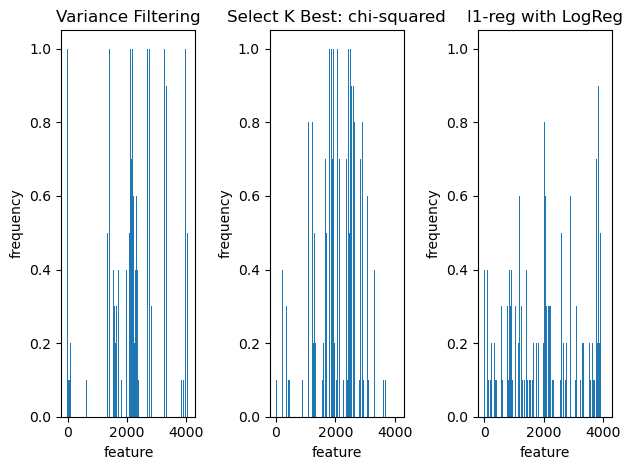

Number of features with frequency > 0.7 for variance filtering: 428 

Number of features with frequency > 0.7 for select K best: 498 

Number of features with frequency > 0.7 for lasso regularization: 122 

Number of features with frequency > 0.7 for shared: 150 



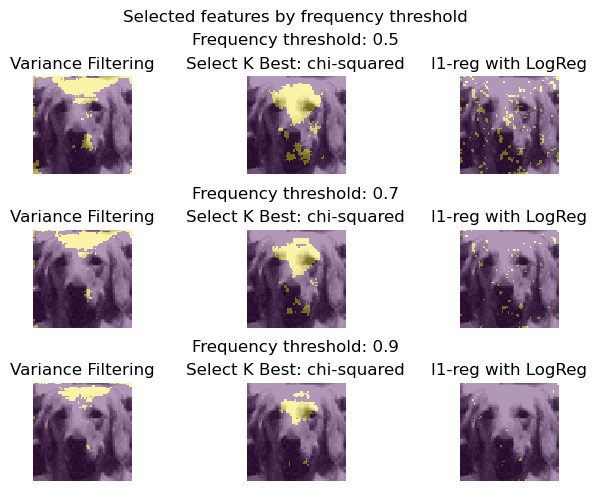

In [14]:
freq_df = bootstrap_selection_methods(features, labels, iter=10)
titles = ['Variance Filtering', 'Select K Best: chi-squared', 'l1-reg with LogReg']
plot_feature_frequencies(freq_df, titles)

threshold = 0.7
methods_top_features = get_methods_top_features(freq_df, threshold)
top_filter = methods_top_features[0]
top_select = methods_top_features[1]
top_sparse = methods_top_features[2]

top_shared = top_filter.intersection(top_select).union(top_filter.intersection(top_sparse)).union(top_select.intersection(top_sparse))

top_feat = {"variance filtering": top_filter, "select K best": top_select, "lasso regularization": top_sparse, "shared": top_shared}
for type, feat in top_feat.items():
    print("Number of features with frequency > %s for %s: %d \n" %(threshold, type, len(feat)))

thresholds = [0.5, 0.7, 0.9]
plot_top_features(features, labels, freq_df, titles, thresholds)

# Variance filtering, features at the edges vary since background color varies
# Select K Best: Sum of normally distributed variables -> chi-squared good? Detects most important features in middle, makes sense
# l1 regularization: How is sparsity viewed in this data?

In [16]:
var_05_freq = get_top_features(features, freq_df.iloc[0,:], 0.9)
write_data_file(var_05_freq, 'varfilter_09_freq.csv')